# Hochschule Bonn-Rhein-Sieg

# Neural Networks, WS17/18

# Assignment 09 (04-December-2017)

##  Debaraj Barua, Naresh Kumar Gurulingan

In [1]:
import numpy as np
import IPython
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import math
import random

## Question 1:

Mindmap of chapter 9:

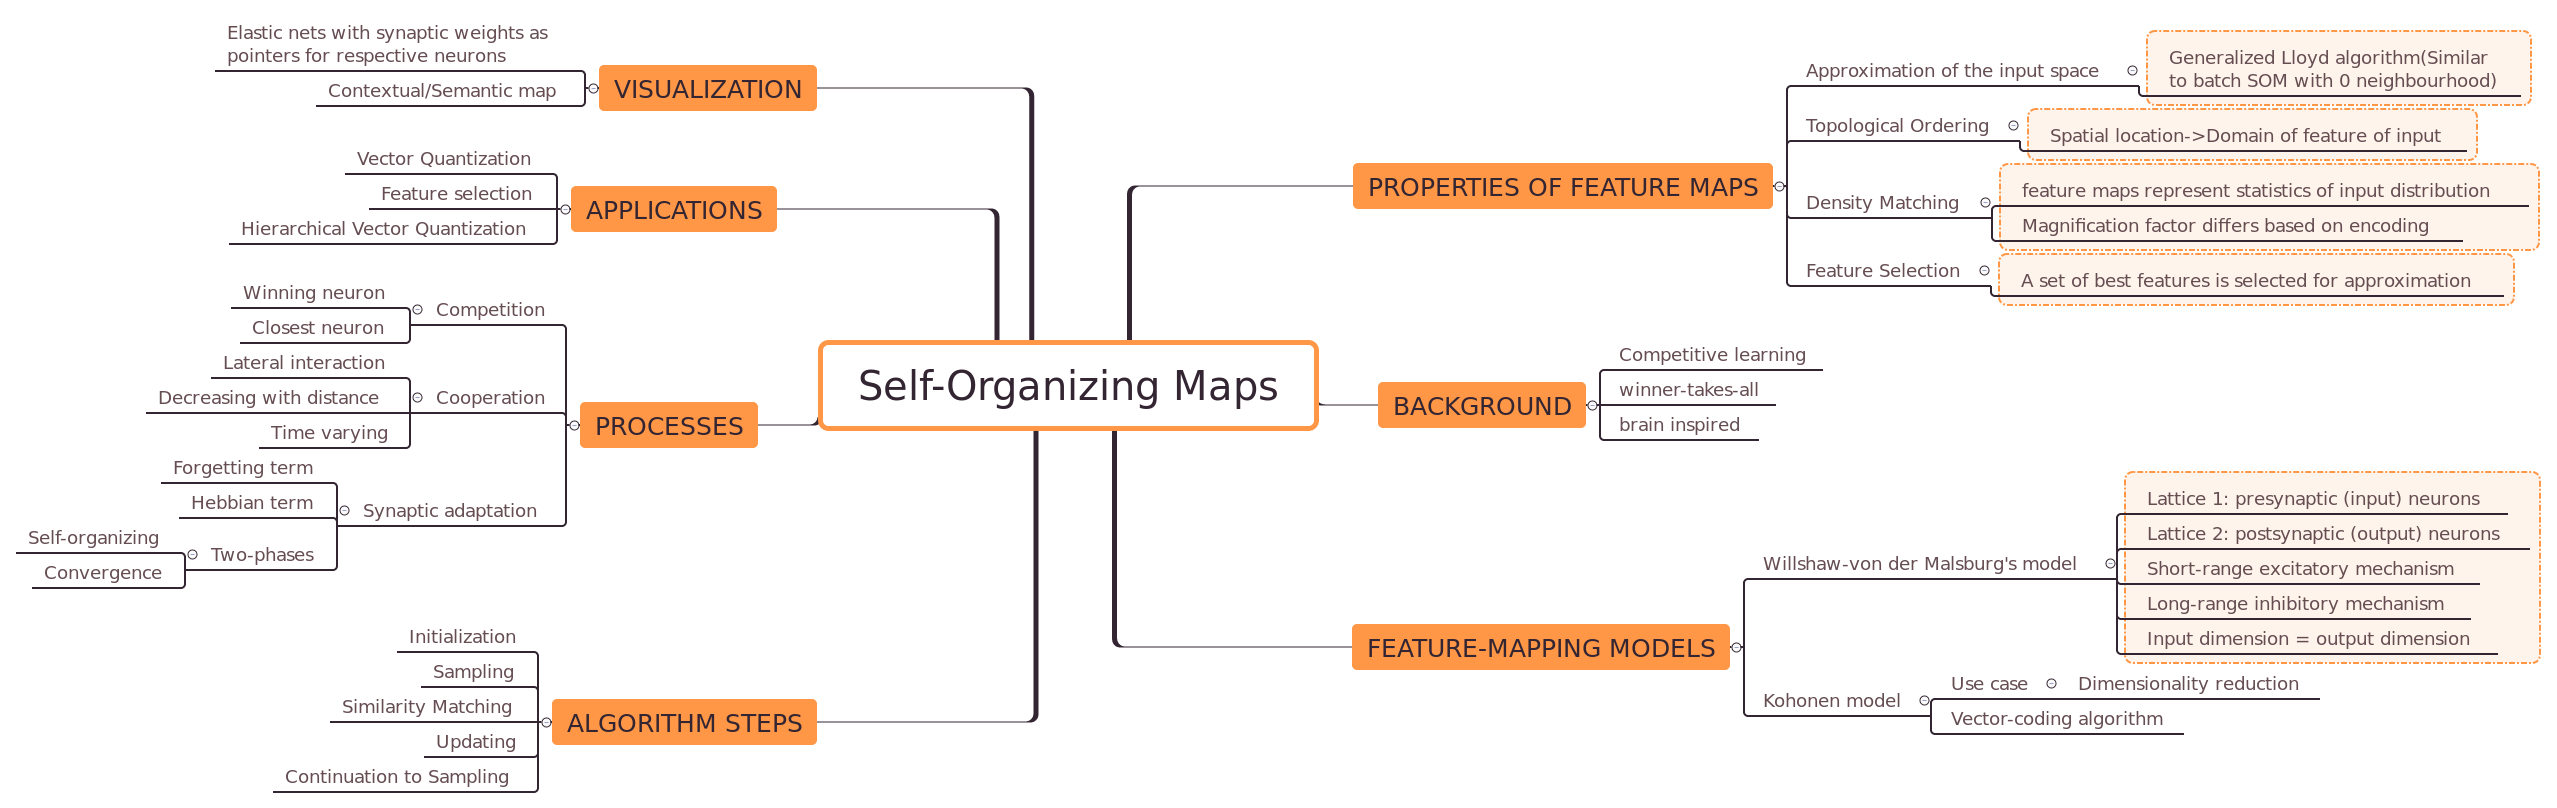

In [2]:
IPython.display.Image('images/mind_map.png')

---
## Question 2:

2) Show that in the SOM algorithm the winner neuron for an input x is that neuron k whose weight vector w_k maximizes the inner product < w_k,x > of x and wk, take x and wk as normalized.

---
## Question 3:

3) Consider the one dimensional input space S={0.1, 0.2, 0.4, 0.5}. Cluster S using a one dimensional SOM network with:

– 2 nodes.

– learning rate equal to 0.1.

– Neighborhood function which is equal to 1 for the winner neuron and is 0 otherwise.

– two Weight initializations:

-- w1=0.15, w2=0.45

-- w1=0.3, w2=0.9

– Stopping criterion: (see PDF)

Comment on the two clusterings you obtained using the two different weight initializations.

In [3]:
NO_CITIES=10
XLIM=100
YLIM=100
ETA=0.1
SIGMA=8
NO_NEURONS=100
T1=1000/np.log(SIGMA)
T2=1000

In [4]:
class SOM():    
    def __init__(self,eta=ETA, epsilon= 0.01, is_TSA= True, 
                 weights= [0, 0], points_1d = [0, 0, 0, 0]):
        
        self.eta=eta
        self.is_TSA = is_TSA
        self.epsilon = epsilon
        
        if is_TSA:
            self.input_vec=generate_pts(NO_CITIES,XLIM,YLIM,typ='cities')
            self.weights=generate_pts(NO_NEURONS,XLIM,YLIM,typ='neurons',
                                      data=self.input_vec)
        else:
            self.input_vec = np.array(points_1d)[np.newaxis].T
            self.weights = np.array(weights)[np.newaxis].T
    
    def decay_eta(self,step):
        if self.is_TSA:
            return ETA*np.exp(-step/T2)
        else:
            return ETA
    
    def decay_width(self,step):
        return SIGMA*np.exp(-step/T1)
    
    def decay_neighbours(self, step, winning_neuron, current_neuron):
        distance=cdist(winning_neuron,current_neuron)
        if self.is_TSA:
            return np.exp(-distance**2/(2*self.decay_width(step)**2))[0,0]
        else:
            return int(winning_neuron == current_neuron)
    
    def som(self):
        cur_iter=0
        
        if self.is_TSA:
            plot_path(self.input_vec,self.weights,title=0,display=True)
            
        while(True):
            
            cur_iter+=1
            sample=self.input_vec[np.random.choice(len(self.input_vec), size=1, 
                                                   replace=False)]
            
            winning_neuron_idx=np.argmin(cdist(self.weights,sample))
            winning_neuron=self.weights[winning_neuron_idx][np.newaxis]
            cur_eta=self.decay_eta(cur_iter)
            old_weights = self.weights.copy()
            
            for idx, neuron in enumerate(self.weights):
                
                neuron=neuron[np.newaxis]
                cur_neighbrs=self.decay_neighbours(cur_iter,winning_neuron,neuron)
                
                self.weights[idx]+=cur_eta*cur_neighbrs*(sample-neuron)[0]
            
            if cur_iter%500==0 and self.is_TSA:
                plot_path(self.input_vec,self.weights,title=cur_iter,
                          display=True)
            elif cur_iter%100==0 and self.is_TSA:
                plot_path(self.input_vec,self.weights,title=cur_iter)
                
            if abs(np.linalg.norm(old_weights - self.weights)) < self.epsilon:
                break
                
        if self.is_TSA == False:
            return self.weights

Initial weights:  [0.15, 0.45]
Resultant clusters:  [ 0.15   0.455]


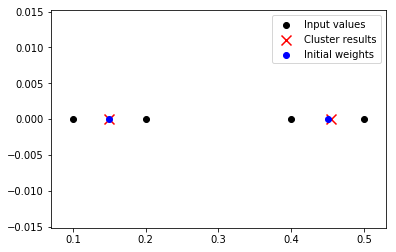

In [5]:
input_space = [0.1, 0.2, 0.4, 0.5]
init_weights = [0.15, 0.45]
som_1d = SOM(is_TSA= False, weights= init_weights, 
            points_1d= input_space)
clusters = som_1d.som()

print 'Initial weights: ', init_weights
print 'Resultant clusters: ', clusters.reshape(-1)

plt.scatter(input_space, [0, 0, 0, 0], color= 'k',
           label= 'Input values')
plt.scatter(clusters, [0, 0], color= 'r', marker= 'x', s=100,
           label= 'Cluster results')
plt.scatter(init_weights, [0, 0], color= 'b',
           label= 'Initial weights')
plt.legend()
plt.show()

Initial weights:  [0.3, 0.9]
Resultant clusters:  [ 0.276968  0.9     ]


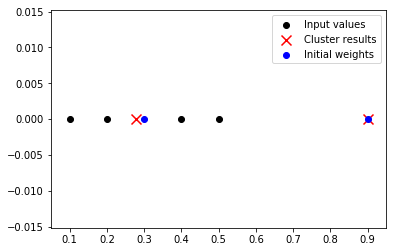

In [6]:
input_space = [0.1, 0.2, 0.4, 0.5]
init_weights = [0.3, 0.9]
som_1d = SOM(is_TSA= False, weights= init_weights, 
            points_1d= input_space)
clusters = som_1d.som()

print 'Initial weights: ', init_weights
print 'Resultant clusters: ', clusters.reshape(-1)

plt.scatter(input_space, [0, 0, 0, 0], color= 'k',
           label= 'Input values')
plt.scatter(clusters, [0, 0], color= 'r', marker= 'x', s=100,
           label= 'Cluster results')
plt.scatter(init_weights, [0, 0], color= 'b',
           label= 'Initial weights')
plt.legend()
plt.show()

---
## Question 4:

4) Implement a SOM to solve the traveling salesman problem (TSP)

In [7]:
def generate_pts(size,xlim,ylim,typ='cities',data=None):
    if typ=='cities':
        x=np.random.random_sample(size)*xlim
        y=np.random.random_sample(size)*ylim  
        data=np.array(x)[np.newaxis].T
        data=np.hstack((data,np.array(y)[np.newaxis].T))
    elif typ=='neurons':
        theta = np.array(np.linspace(0,2*np.pi,size))        
        r = random.randint(size/10,size/4)
        c_x=(np.amax(data,axis=0)[0]-np.amin(data,axis=0)[0])/2
        c_y=(np.amax(data,axis=0)[1]-np.amin(data,axis=0)[1])/2
        
        x= c_x + r * np.cos(theta) 
        y= c_y + r * np.sin(theta)        
        
        data=np.array(x)[np.newaxis].T
        data=np.hstack((data,np.array(y)[np.newaxis].T))
    return data

def plot_path(cities,weights,title=None,display=False):
    col_cities='red'
    col_weights='yellow'
    weights=np.vstack((weights,weights[0,:]))
    plt.scatter(cities[:,0],cities[:,1],label='scattered cities', 
                marker='x', color=col_cities)
    plt.plot(weights[:,0],weights[:,1],label='current path',
             marker='o',color=col_weights)
    plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=1.)
    
    if title:
        plt.title('Iteration #{:06d}'.format(title))
    
    plt.savefig('results/{}.png'.format(title))
    
    if display:
        plt.show()
    
    plt.clf()      

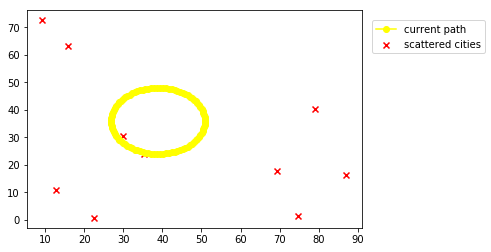

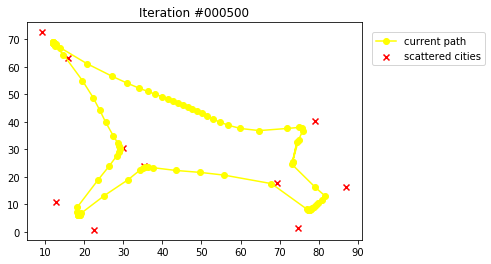

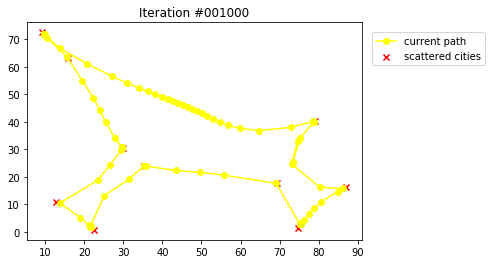

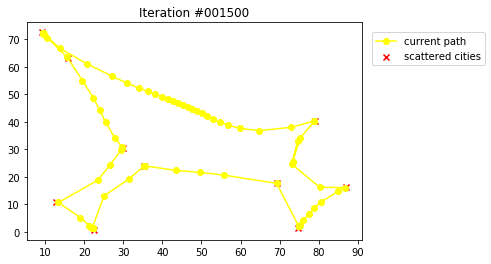

In [8]:
som=SOM(epsilon= 0.001).som()